In [2]:
import numpy as np
import matplotlib.pyplot as plt
import weno4 as weno
from tqdm import tqdm
outdir = r"C:\Users\nickd\PyFluid\gifs"

100%|██████████| 10000/10000 [00:01<00:00, 8196.46it/s]


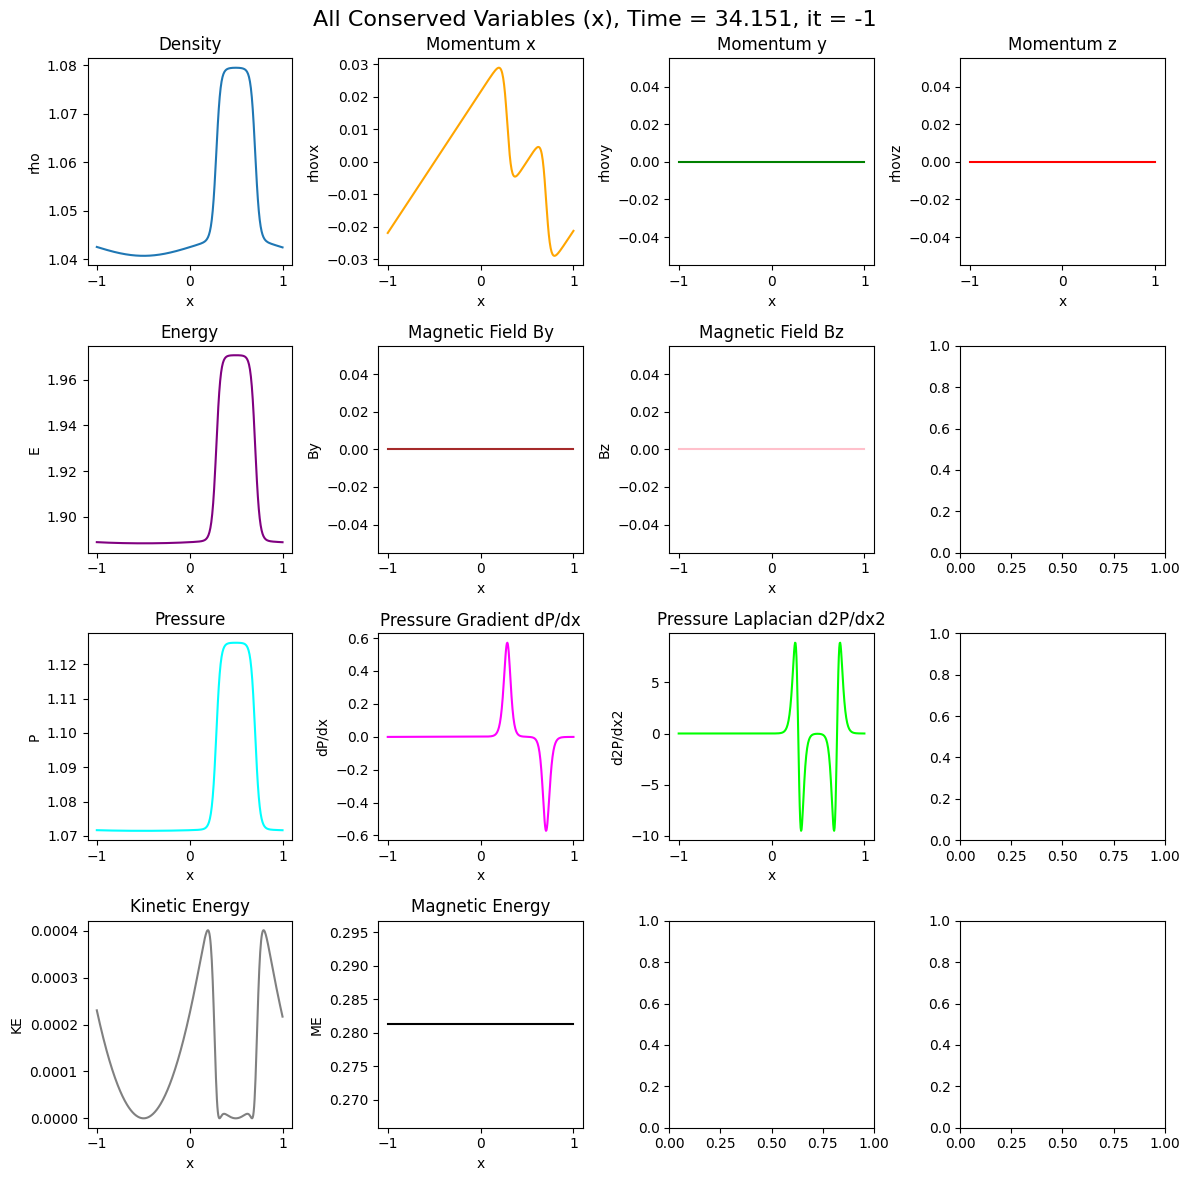

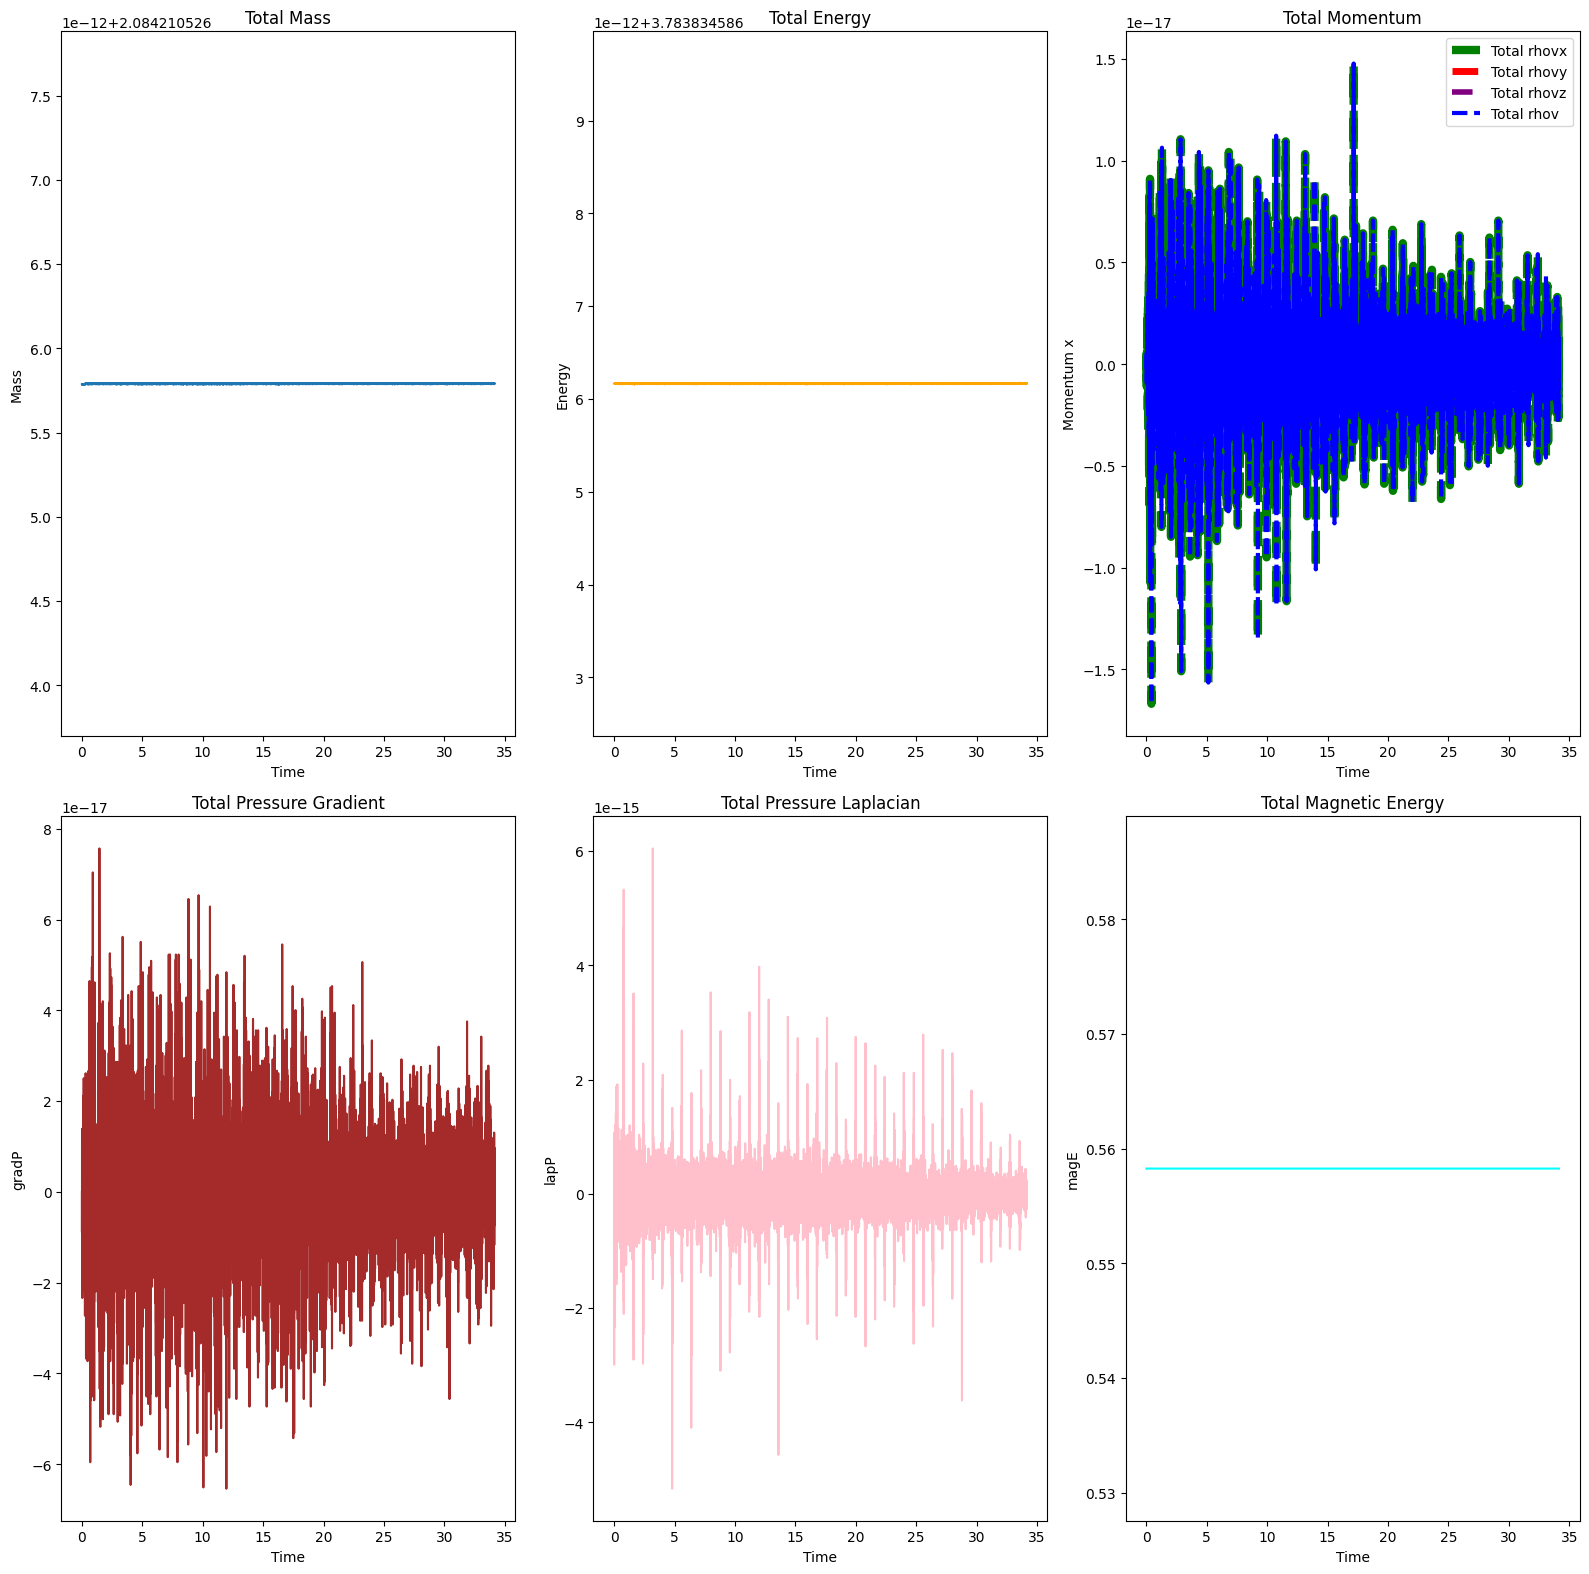

In [189]:
#1 Dimension MHD, Compressible, Adiabatic, Inviscid, No Viscosity, No Resistivity
def calc_minmod(rf,out):
   out[...] = np.where(np.sign(a) == np.sign(b), np.sign(a)*np.minimum(np.abs(a),np.abs(b)), 0.0)

def calc_superbee(ed,out):
   out[...] = np.maximum(0,)

class fluid1DMHD:
   def __init__(self,x0,x1,nx,ici,bci,nsteps,limi):
      #Initialize the base grid, ghost cells and interior.
      self.nsteps = int(nsteps)
      self.step= 0 #current iteration
      self.x0,self.x1 = x0,x1
      self.nx = int(nx)
      self.ici = ici; self.bci = bci;
      self.ng = 2 #number of ghost cells
      self.xg = np.linspace(x0,x1,nx) #grid with ghost cells
      self.dx = self.xg[1]-self.xg[0];
      self.xi = self.xg[self.ng:-self.ng] #interior grid
      self.nxi = self.nx - 2*self.ng #number of interior grid points
      self.nxifs = self.nxi + 1 #number of interfaces
      self.xgi = np.linspace(self.xg[self.ng]-0.5*self.dx,self.xg[-self.ng-1]+0.5*self.dx,self.nxifs) #grid interfaces
      self.limi = limi
      assert(self.xgi[1]-self.xgi[0] == self.dx)
      self.L = self.x1-self.x0 #domain length
      self.Li = self.xg[-self.ng] - self.xg[self.ng] #interior domain length
      self.gmask = np.zeros(nx,dtype=bool);
      self.gmask[:self.ng] = True; self.gmask[-self.ng:] = True
      self.imask = ~self.gmask
      self.lhgsl = slice(0,self.ng) #left side ghost cell slice
      self.lhisl = slice(self.ng,2*self.ng) #left side interior slice
      self.rhgsl = slice(-self.ng,None) #right side ghost cell slice
      self.rhisl = slice(-2*self.ng,-self.ng) #right side interior
      self.lhsmask = np.zeros(nx,dtype=bool); self.lhsmask[np.where(self.xg <= 0)] = True #left half domain
      self.lhsmask[0:self.ng] = False;
      self.rhsmask = np.zeros(nx,dtype=bool); self.rhsmask[np.where(self.xg > 0 )] = True #right half domain
      self.rhsmask[-self.ng:] = False;
      self.t = 0.0; self.dt = 0.0;
      self.cflr = 0.9 #CFL ratio, run at 90% of max stable timestep
      self.ts = np.zeros(self.nsteps+1) #time storage
      self.dts = np.zeros(self.nsteps) #dt storage
      #1D MHD we have 7 variables (rho, rhovx, rhovy, rhovz, E, By, Bz) as our conserved variables
      # rho, 3 velocities, energy 2 magnetic fields
      self.nvar = 7;
      self.Uvec = np.zeros((self.nvar,nx)) #conserved variable state vector
      self.UvecintL= np.zeros((self.nvar,self.nxifs)) #interface conserved variable state vector
      self.UvecintR= np.zeros((self.nvar,self.nxifs)) #interface conserved variable state vector
      self.Uvecs = np.zeros((self.nsteps+1,self.nvar,nx)) #conserved variable state vector storage
      self.Fvec = np.zeros((self.nvar,nx)) #flux vector


      self.auxvar = 12; #number of auxiliary variables, (vx,vy,vz,P,gradPx,lapP,KE,magE,cs2,cs2Ax,cs2A,cs2f)
      self.Auxvec = np.zeros((self.auxvar,nx)) #auxiliary variable state vector

      self.Auxvecs = np.zeros((self.nsteps+1,self.auxvar,nx)) #auxiliary variable state vector storage
      self.diagvar = 9; #Diagnostic scalars total(mass, energy, rhovx, rhovy, rhovz, rhov, gradP, lapP, magE)
      self.diagnostics = np.zeros((self.nsteps+1,self.diagvar)) #diagnostic scalars storage
      self.alphaint = np.zeros(self.nxifs) #max wave speed at interfaces
      if self.ng == 2:
         #ng - 2 = 0
         self.outeri = None;
      else:
         self.outeri = -(self.ng -2);
      if self.limi == 0:
         self.calc_slopelimit = calc_minmod
      elif self.limi == 1:
         self.calc_slopelimit = calc_superbee
      elif self.limi == 2:
         self.calc_slopelimit = calc_vanleer
      elif self.limi == 3:
         self.calc_slopelimit = calc_mc

      #Physics Assumptions
      self.gamma = 5/3 #adiabatic index
      self.kappa = 1.0 #entropy
      self.rhob = 1.0 #background density
      self.pres0 = self.kappa*self.rhob**self.gamma #background pressure
      self.cs20 = self.gamma*self.kappa*self.rhob**(self.gamma-1) #background sound speed squared
      self.Bx = 0.75 #background magnetic field in x direction
      self.By0= 0.0
      self.Bz0 = 0.0

      #initialize conserved variables
      self.apply_ics()
      self.sync_state() #BC's and aux variables
      #Save initial state
      self.Uvecs[0,:,:] = self.Uvec
      self.Auxvecs[0,:,:] = self.Auxvec
      
      self.run_and_store()

      #After Run is done
      self.compute_diagnostics()

   def run_and_store(self):
      for i in tqdm(range(self.nsteps)):
         #Update conserved variables with LLF
         self.calc_llfand_update()
         #BC's and aux variables
         self.sync_state()
         self.t += self.dt
         self.step += 1
         self.save_state(self.step)

   def sync_state(self):
      self.apply_bcs()
      self.calc_aux(self.Uvec,self.Auxvec)
      self.calc_anfluxes(self.Uvec,self.Auxvec,self.Fvec)

   def apply_ics(self):
      self.delrho = (1e-1)*self.rhob;
      self.delP = self.delrho*self.cs20;
      self.Uvec[0,self.imask] += self.rhob #background density
      self.Auxvec[3,self.imask] += self.pres0 #background pressure
      self.U0width = 0.25
      if self.ici == 0:
         #Sod shock tube
         self.Uvec[5,self.imask] -= 2*self.By0 #background By magnetic field
         self.Uvec[0,self.lhsmask]   += self.delrho #density perturbation
         self.Auxvec[3,self.lhsmask] += self.delP #pressure perturbation
         self.Uvec[5,self.lhsmask]   += self.By0 #By magnetic field
         self.Uvec[6,self.lhsmask]   += self.Bz0 #Bz magnetic field
      if self.ici == 1:
         #square pulse
         sqmask = np.where(np.abs(self.xi) < self.U0width)
         self.Uvec[0,sqmask] += self.delrho #density perturbation
         self.Auxvec[3,sqmask] += self.delP #pressure perturbation
      if self.ici ==2:
         #gaussian pulse
         self.Uvec[0,self.imask]+=np.exp(-np.square(self.xi)/(2*self.U0width**2))*self.delrho #density perturbation
         self.Auxvec[3,self.imask]+=np.exp(-np.square(self.xi)/(2*self.U0width**2))*self.delP #pressure perturbation
      if self.ici == 3:
         #Linear wave
         self.kx = (2*np.pi/self.Li) #wave number
         self.Uvec[0,self.imask] += self.delrho*np.sin(self.kx*self.xi) #density perturbation
         self.Auxvec[3,self.imask] += self.delP*np.sin(self.kx*self.xi) #pressure perturbation
         self.Uvec[1,self.imask] += (np.sqrt(self.cs20)*self.delrho)*np.sin(self.kx*self.xi) #velocity perturbation
      if self.ici not in [0,1,2,3]:
         raise ValueError("Initial condition not recognized.")
      self.Auxvec[6,self.imask] = 0.5*np.square(self.Uvec[1:4,self.imask]).sum(axis=0)/self.Uvec[0,self.imask] #kinetic energy
      self.Auxvec[7,self.imask] = 0.5*(np.square(self.Uvec[5:7,self.imask]).sum(axis=0) + (self.Bx**2)) #magnetic energy
      self.calc_energy(self.Auxvec)
      
   def calc_energy(self,auxvecf):
       self.Uvec[4,:] = auxvecf[3,:]/(self.gamma-1) + auxvecf[6,:] + auxvecf[7,:]
         
   def calc_aux(self,uvecf,auxvecf):
      #Calc aux variables
      auxvecf[0:3,:] = uvecf[1:4,:]/uvecf[0,:] #velocities
      auxvecf[6,:] = 0.5*uvecf[0,:]*np.square(auxvecf[0:3,:]).sum(axis=0) #kinetic energy
      auxvecf[7,:] = 0.5*np.square(uvecf[5:,:]).sum(axis=0) + 0.5*(self.Bx**2) #magnetic energy
      auxvecf[3,:] = (self.gamma-1)*(uvecf[4,:] - auxvecf[6,:] - auxvecf[7,:]) #pressure
      auxvecf[4,:] = np.gradient(auxvecf[3,:],self.dx) #pressure gradient
      auxvecf[5,:] = np.gradient(auxvecf[4,:],self.dx) #pressure laplacian
      auxvecf[8,:] = self.gamma*auxvecf[3,:]/uvecf[0,:] #sound speed squared
      auxvecf[9,:] = np.square(self.Bx)/uvecf[0,:] #Alfven speed squared in x direction
      auxvecf[10,:] = 2* auxvecf[7,:]/uvecf[0,:] #total Alfven speed squared
      auxvecf[11,:] = 0.5*(auxvecf[8,:] + auxvecf[10,:] \
                  + np.sqrt((auxvecf[8,:] + auxvecf[10,:])**2 - 4*auxvecf[8,:]*auxvecf[9,:])) #fast magnetosonic speed squared
   
   def LRrecon_all(self):
         pass
   
   def calc_dt(self):
      self.dt = self.cflr*self.dx/np.max(np.sqrt(self.Auxvec[11,:])) #dt from CFL condition

   def wenorecon_all(self,uvecf,auxvecf,uvecintf,auxvecintf,fluxvecintf):
      for i in range(self.nvar):
         uvecintf[i,:] = weno.weno4(self.xgi,self.xg,uvecf[i,:])
      for i in range(self.auxvar):
         auxvecintf[i,:] = weno.weno4(self.xgi,self.xg,auxvecf[i,:])
      self.calc_anfluxes(uvecintf,auxvecintf,fluxvecintf);
   
   def calc_llfand_update(self):
      self.alphaint = np.sqrt(np.maximum(self.Auxvec[11,self.ng-1:-(self.ng)],self.Auxvec[11,self.ng:-(self.ng-1)])) #max wave speed at interfaces
      self.dt = self.cflr*self.dx/np.max(self.alphaint) #dt from CFL condition, use interior of alpha
      self.Fvecint = 0.5*(self.Fvec[:,self.ng-1:-(self.ng)] + self.Fvec[:,self.ng:-(self.ng-1)]) \
              - 0.5*self.alphaint*(self.Uvec[:,self.ng:-(self.ng-1)]  - self.Uvec[:,(self.ng-1):-(self.ng)]);
      self.Uvec[:,self.imask] -= (self.dt/self.dx)*(self.Fvecint[:,1:] - self.Fvecint[:,:-1]) 
   
   def calc_anfluxes(self,uvecf, auxvecf, fluxvecf):
      fluxvecf[0,:] = uvecf[1,:] #mass flux
      fluxvecf[1:4,:] = uvecf[1,:]*auxvecf[0:3,:] \
            - self.Bx*np.vstack([self.Bx*np.ones(len(uvecf[0,:])),uvecf[5:7,:]]) #momentum fluxes
      fluxvecf[1,:] += auxvecf[3,:] #add pressure to x momentum flux
      fluxvecf[4,:] = (uvecf[4,:] + auxvecf[3,:])*auxvecf[0,:] - self.Bx**2*auxvecf[0,:] \
                     - self.Bx*np.sum(uvecf[5:,:]*auxvecf[1:3,:],axis=0) #energy flux
      fluxvecf[5:7,:] = uvecf[5:,:]*auxvecf[0,:] - self.Bx*auxvecf[1:3,:] #By,Bz flux

   def compute_diagnostics(self):
      self.diagnostics[:,0] = np.sum(self.Uvecs[:,0,self.imask],axis=1)*self.dx #total mass
      self.diagnostics[:,1] = np.sum(self.Uvecs[:,4,self.imask],axis=1)*self.dx #total energy
      self.diagnostics[:,2] = np.sum(self.Uvecs[:,1,self.imask],axis=1)*self.dx #total rhovx
      self.diagnostics[:,3] = np.sum(self.Uvecs[:,2,self.imask],axis=1)*self.dx #total rhovy
      self.diagnostics[:,4] = np.sum(self.Uvecs[:,3,self.imask],axis=1)*self.dx #total rhovz
      self.diagnostics[:,5] = self.diagnostics[:,2:5].sum(axis=1) #total rhov
      self.diagnostics[:,6] = np.sum(self.Auxvecs[:,4,self.imask],axis=1)*self.dx #total gradP
      self.diagnostics[:,7] = np.sum(self.Auxvecs[:,5,self.imask],axis=1)*self.dx #total lapP
      self.diagnostics[:,8] = np.sum(self.Auxvecs[:,7,self.imask],axis=1)*self.dx #total magE

   def save_state(self,itf):
      self.Uvecs[itf,:,:] = self.Uvec
      self.Auxvecs[itf,:,:] = self.Auxvec
      self.ts[itf] = self.t
      self.dts[itf-1] = self.dt

   def apply_bcs(self):
      #LHS Periodic
      if self.bci[0] == 0:
         self.Uvec[:,self.lhgsl] = self.Uvec[:,self.rhisl]
      #RHS Periodic
      if self.bci[1] == 0:
         self.Uvec[:,self.rhgsl] = self.Uvec[:,self.lhisl]
     
      #LHS Outflow
      if self.bci[0] == 1:
         self.Uvec[:,self.lhgsl] = self.Uvec[:,self.lhisl]
      #RHS Outflow
      if self.bci[1] == 1:
         self.Uvec[:,self.rhgsl] = self.Uvec[:,self.rhisl]
      
      #LHS Reflective
      if self.bci[0] == 2:
         self.Uvec[:,self.lhgsl] = self.Uvec[:,self.lhisl]
         self.Uvec[1:4,self.lhgsl] *= -1
      #RHS Reflective
      if self.bci[1] == 2:
         self.Uvec[:,self.rhgsl] = self.Uvec[:,self.rhisl]
         self.Uvec[1:4,self.rhgsl] *= -1
      if self.bci[0] not in [0,1,2] or self.bci[1] not in [0,1,2]:
         raise ValueError("Boundary condition not recognized. Use 0 = periodic, 1 = outflow, 2 = reflective")
      
   def plot_all(self,itf):
      fig,axs = plt.subplots(4,4,figsize=(12,12))
      suptitle = f'All Conserved Variables (x), Time = {self.ts[itf]:.3f}, it = {itf}'
      fig.suptitle(suptitle,fontsize=16)
      #Density
      axs[0,0].plot(self.xg,self.Uvecs[itf,0,:],label='Density')
      axs[0,0].set_title('Density' )
      axs[0,0].set_xlabel('x')
      axs[0,0].set_ylabel('rho')
      #Momentum x
      axs[0,1].plot(self.xg,self.Uvecs[itf,1,:],label='Momentum x',color='orange')
      axs[0,1].set_title('Momentum x')
      axs[0,1].set_xlabel('x')
      axs[0,1].set_ylabel('rhovx')
      #Momentum y
      axs[0,2].plot(self.xg,self.Uvecs[itf,2,:],label='Momentum y',color='green')
      axs[0,2].set_title('Momentum y')
      axs[0,2].set_xlabel('x')
      axs[0,2].set_ylabel('rhovy')
      #Momentum z
      axs[0,3].plot(self.xg,self.Uvecs[itf,3,:],label='Momentum z',color='red')
      axs[0,3].set_title('Momentum z')
      axs[0,3].set_xlabel('x')
      axs[0,3].set_ylabel('rhovz')
      #Energy
      axs[1,0].plot(self.xg,self.Uvecs[itf,4,:],label='Energy',color='purple')
      axs[1,0].set_title('Energy')
      axs[1,0].set_xlabel('x')
      axs[1,0].set_ylabel('E')   
      #By  
      axs[1,1].plot(self.xg,self.Uvecs[itf,5,:],label='By',color='brown')
      axs[1,1].set_title('Magnetic Field By')
      axs[1,1].set_xlabel('x')
      axs[1,1].set_ylabel('By')
      #Bz
      axs[1,2].plot(self.xg,self.Uvecs[itf,6,:],label='Bz',color='pink')
      axs[1,2].set_title('Magnetic Field Bz')
      axs[1,2].set_xlabel('x')
      axs[1,2].set_ylabel('Bz')
      #Pressure
      axs[2,0].plot(self.xg,self.Auxvecs[itf,3,:],label='Pressure',color='cyan')
      axs[2,0].set_title('Pressure')
      axs[2,0].set_xlabel('x')
      axs[2,0].set_ylabel('P')
      #grad Px
      axs[2,1].plot(self.xg,self.Auxvecs[itf,4,:],label='Pressure Gradient',color='magenta')
      axs[2,1].set_title('Pressure Gradient dP/dx')
      axs[2,1].set_xlabel('x')
      axs[2,1].set_ylabel('dP/dx')
      #lap P
      axs[2,2].plot(self.xg,self.Auxvecs[itf,5,:],label='Pressure Laplacian',color='lime')
      axs[2,2].set_title('Pressure Laplacian d2P/dx2')
      axs[2,2].set_xlabel('x')
      axs[2,2].set_ylabel('d2P/dx2')
      #Kinetic Energy
      axs[3,0].plot(self.xg,self.Auxvecs[itf,6,:],label='Kinetic Energy',color='grey')
      axs[3,0].set_title('Kinetic Energy')
      axs[3,0].set_xlabel('x')
      axs[3,0].set_ylabel('KE')
      #Magnetic Energy
      axs[3,1].plot(self.xg,self.Auxvecs[itf,7,:],label='Magnetic Energy',color='black')
      axs[3,1].set_title('Magnetic Energy')
      axs[3,1].set_xlabel('x')
      axs[3,1].set_ylabel('ME')
      plt.tight_layout()

   def plot_diagnostics(self):
      fig,axs = plt.subplots(2,3,figsize=(16,16))
      #Total Mass
      axs[0,0].plot(self.ts,self.diagnostics[:,0],label='Total Mass')
      axs[0,0].set_title('Total Mass')
      axs[0,0].set_xlabel('Time')
      axs[0,0].set_ylabel('Mass')
      #Total Energy  
      axs[0,1].plot(self.ts,self.diagnostics[:,1],label='Total Energy',color='orange')
      axs[0,1].set_title('Total Energy')
      axs[0,1].set_xlabel('Time')
      axs[0,1].set_ylabel('Energy')
      #Total Momentum plot
      axs[0,2].set_title('Total Momentum')
      axs[0,2].set_xlabel('Time')
      axs[0,2].set_ylabel('Momentum x')
      #Total rhovx
      axs[0,2].plot(self.ts,self.diagnostics[:,2],"--",lw=6,label='Total rhovx',color='green')
      #Total rhovy
      axs[0,2].plot(self.ts,self.diagnostics[:,3],"--",lw=5,label='Total rhovy',color='red')
      #Total rhovz
      axs[0,2].plot(self.ts,self.diagnostics[:,4],"--",lw=4,label='Total rhovz',color='purple')
      #Total rhov
      axs[0,2].plot(self.ts,self.diagnostics[:,5],"--",lw=3,label='Total rhov',color='blue')
      axs[0,2].legend()
      #Total gradP
      axs[1,0].plot(self.ts,self.diagnostics[:,6],label='Total gradP',color='brown')
      axs[1,0].set_title('Total Pressure Gradient')
      axs[1,0].set_xlabel('Time')
      axs[1,0].set_ylabel('gradP')
      #Total lapP
      axs[1,1].plot(self.ts,self.diagnostics[:,7],label='Total lapP',color='pink')
      axs[1,1].set_title('Total Pressure Laplacian')
      axs[1,1].set_xlabel('Time')
      axs[1,1].set_ylabel('lapP')
      #Total magE
      axs[1,2].plot(self.ts,self.diagnostics[:,8],label='Total magE',color='cyan')
      axs[1,2].set_title('Total Magnetic Energy')
      axs[1,2].set_xlabel('Time')
      axs[1,2].set_ylabel('magE')
      plt.tight_layout()

#Simulation parameters
x0 = -1.0; x1 = 1.0; nx= 400;
#Initial conditions, 0 = sod shock, 1 = square pulse, 2 = gaussian pulse, 3 = wave
ici = 0;
#Boundary conditions, 0 = periodic, 1 = outflow, 2 = reflective
bci = np.array([0,0]);
#Limiteri
limi = 0; #0 = minmod, 1 = superbee, 2 = Van-Leer, 3= MC


Nsteps = 1e4;
state = fluid1DMHD(x0,x1,nx,ici,bci,Nsteps,limi);
state.plot_all(-1)
state.plot_diagnostics()


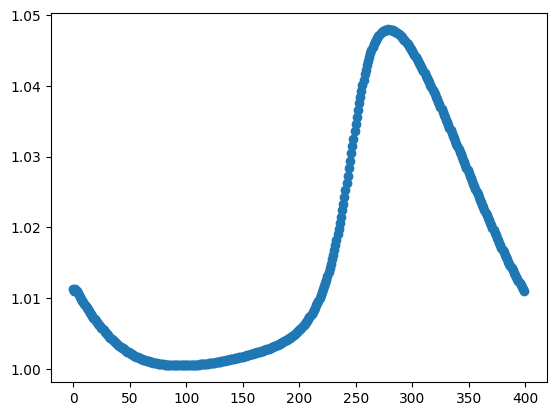

In [181]:
#it = 0
it +=10
plt.plot(state.Uvecs[it,0,:], "-o")